In [1]:
import glob
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import scipy.stats as stats
import utils
import pandas_market_calendars as mcal

In [13]:
ampm = 'afternoon'
path = f'{ampm}_df_*.csv'

all_files = glob.glob(path)

li = []

for filename in tqdm(all_files):
    df = pd.read_csv(filename, index_col=None, header=0,parse_dates=['time'])
    li.append(df)
    
df = pd.concat(li, axis=0, ignore_index=True)
df = df.set_index('time')
df = df.sort_index()

100%|██████████| 5/5 [00:00&lt;00:00,  5.59it/s]


In [14]:
df = df.drop(['gaps','weekday'],axis=1)

In [15]:
nyse = mcal.get_calendar('NYSE')
working_days = nyse.valid_days(start_date='2016-01-01', end_date='2019-12-31')

In [16]:
len(df.groupby(df.index.date))

1291

In [17]:
working_days.date

array([datetime.date(2016, 1, 4), datetime.date(2016, 1, 5),
       datetime.date(2016, 1, 6), ..., datetime.date(2019, 12, 27),
       datetime.date(2019, 12, 30), datetime.date(2019, 12, 31)],
      dtype=object)

In [18]:
ngroups  = len(df.groupby(df.index.date))
count = 0
wd_only = []
for group in df.groupby(df.index.date):
    if working_days.date[working_days.date == group[0]].any():
        wd_only.append(group[1])
        count += 1
df = pd.concat(wd_only, axis=0, ignore_index=False)
count/ngroups

0.6359411309062742

In [19]:
df_norm = df.copy()

below_freezing = (df_norm['tmpf']<32).astype(int)
df_norm['lt_32'] = below_freezing

In [20]:
df_norm.std().to_csv(f'std_{ampm}.csv')
df_norm.mean().to_csv(f'mean_{ampm}.csv')

In [21]:
df_norm = (df_norm-df_norm.mean())/df_norm.std()
df_norm['p01i'] = df['p01i']**(1/3)

In [22]:
df_norm = df_norm.bfill()
df_norm = df_norm.interpolate('linear')

df_norm.to_csv(f'merged_df_{ampm}.csv')

In [13]:
len(df_norm[df_norm['lt_32']>1])/4

629.25

In [14]:
df_norm[df_norm['lt_32']>1].corr()

,p01i,tmpf,tmpf_pred,p01i_pred,speed,hour,speed_diff,lt_32
p01i,1.000000e+00,1.752784e-01,1.872982e-01,6.870602e-01,-2.825913e-01,-4.526835e-02,2.398944e-02,3.570632e-15
tmpf,1.752784e-01,1.000000e+00,9.712014e-01,1.017034e-01,-1.123862e-01,2.084798e-02,-4.206663e-03,7.105100e-14
tmpf_pred,1.872982e-01,9.712014e-01,1.000000e+00,9.420044e-02,-1.142324e-01,-9.059998e-02,1.451490e-02,1.027348e-14
p01i_pred,6.870602e-01,1.017034e-01,9.420044e-02,1.000000e+00,-2.189521e-01,-8.099028e-02,3.506241e-02,9.344196e-17
speed,-2.825913e-01,-1.123862e-01,-1.142324e-01,-2.189521e-01,1.000000e+00,-8.013216e-03,6.145689e-02,6.163049e-16
hour,-4.526835e-02,2.084798e-02,-9.059998e-02,-8.099028e-02,-8.013216e-03,1.000000e+00,-2.789435e-01,4.240777e-16
speed_diff,2.398944e-02,-4.206663e-03,1.451490e-02,3.506241e-02,6.145689e-02,-2.789435e-01,1.000000e+00,-2.328862e-17
lt_32,3.570632e-15,7.105100e-14,1.027348e-14,9.344196e-17,6.163049e-16,4.240777e-16,-2.328862e-17,1.000000e+00


In [15]:
df['speed'].std()

8.5160458099861

<ipython-input-16-0a7815623f5b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cold['speed'] = cold['speed']*df['speed'].std()+df['speed'].mean()
<ipython-input-16-0a7815623f5b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  icy['speed'] = icy['speed']*df['speed'].std()+df['speed'].mean()


Text(0.5, 1.0, 'morning')

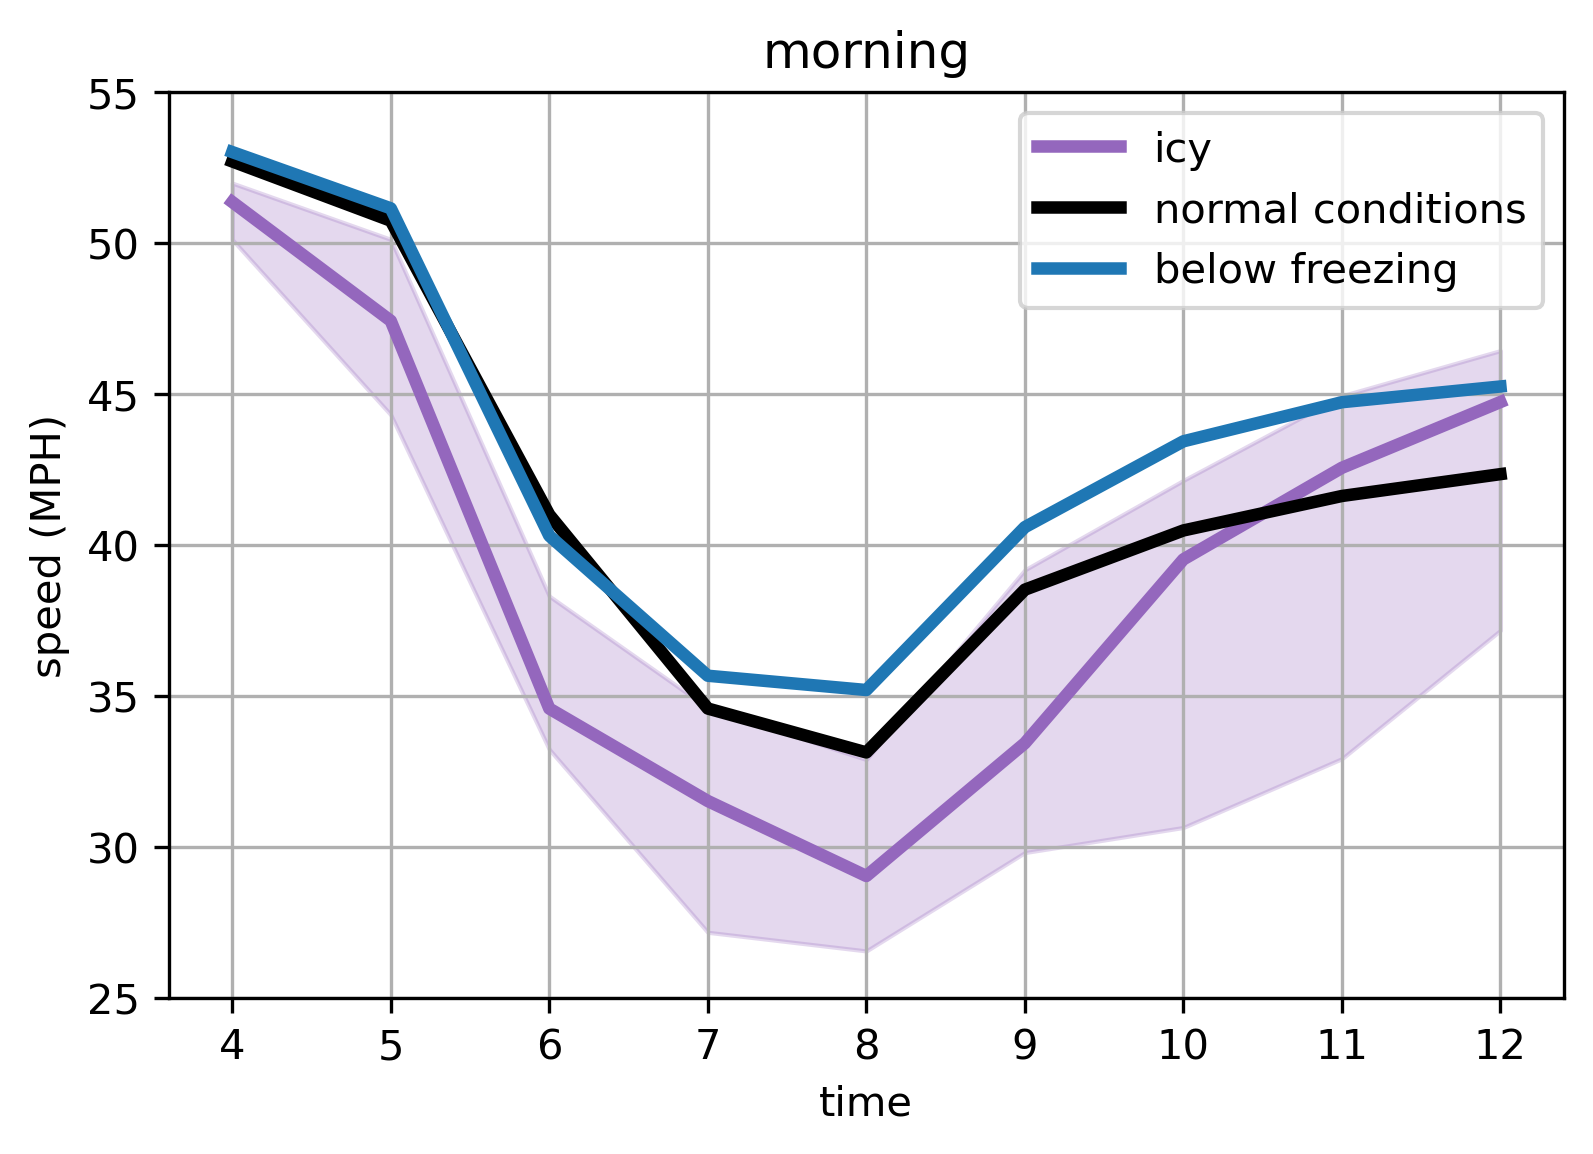

In [16]:
plt.figure(dpi=300)

cold =df_norm[df_norm['lt_32']>1]
icy = df_norm[(df_norm['lt_32']>1) & (df_norm['p01i']>0)]
normal = df_norm['speed'].groupby(df_norm['speed'].index.hour).median()*df['speed'].std()+df['speed'].mean()

cold['speed'] = cold['speed']*df['speed'].std()+df['speed'].mean()
icy['speed'] = icy['speed']*df['speed'].std()+df['speed'].mean()


uq = icy.groupby(icy.index.hour)['speed'].quantile(.75)
lq = icy.groupby(icy.index.hour)['speed'].quantile(.25)
median = icy.groupby(icy.index.hour).median()['speed']

median.plot(lw=3,label='icy',c='tab:purple')
plt.fill_between(uq.index,uq,lq,alpha=0.25,color='tab:purple')

normal.plot(label='normal conditions',lw=3,c='k')
cold.groupby(cold.index.hour).median()['speed'].plot(label='below freezing',lw=3)

plt.grid()
plt.ylabel('speed (MPH)')
plt.legend()
plt.ylim(25,55)
plt.title(ampm)

<ipython-input-28-c3d252fc5916>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rainy['speed'] = rainy['speed']*df['speed'].std()+df['speed'].mean()
<ipython-input-28-c3d252fc5916>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hrain['speed'] = hrain['speed']*df['speed'].std()+df['speed'].mean()


Text(0.5, 1.0, 'morning')

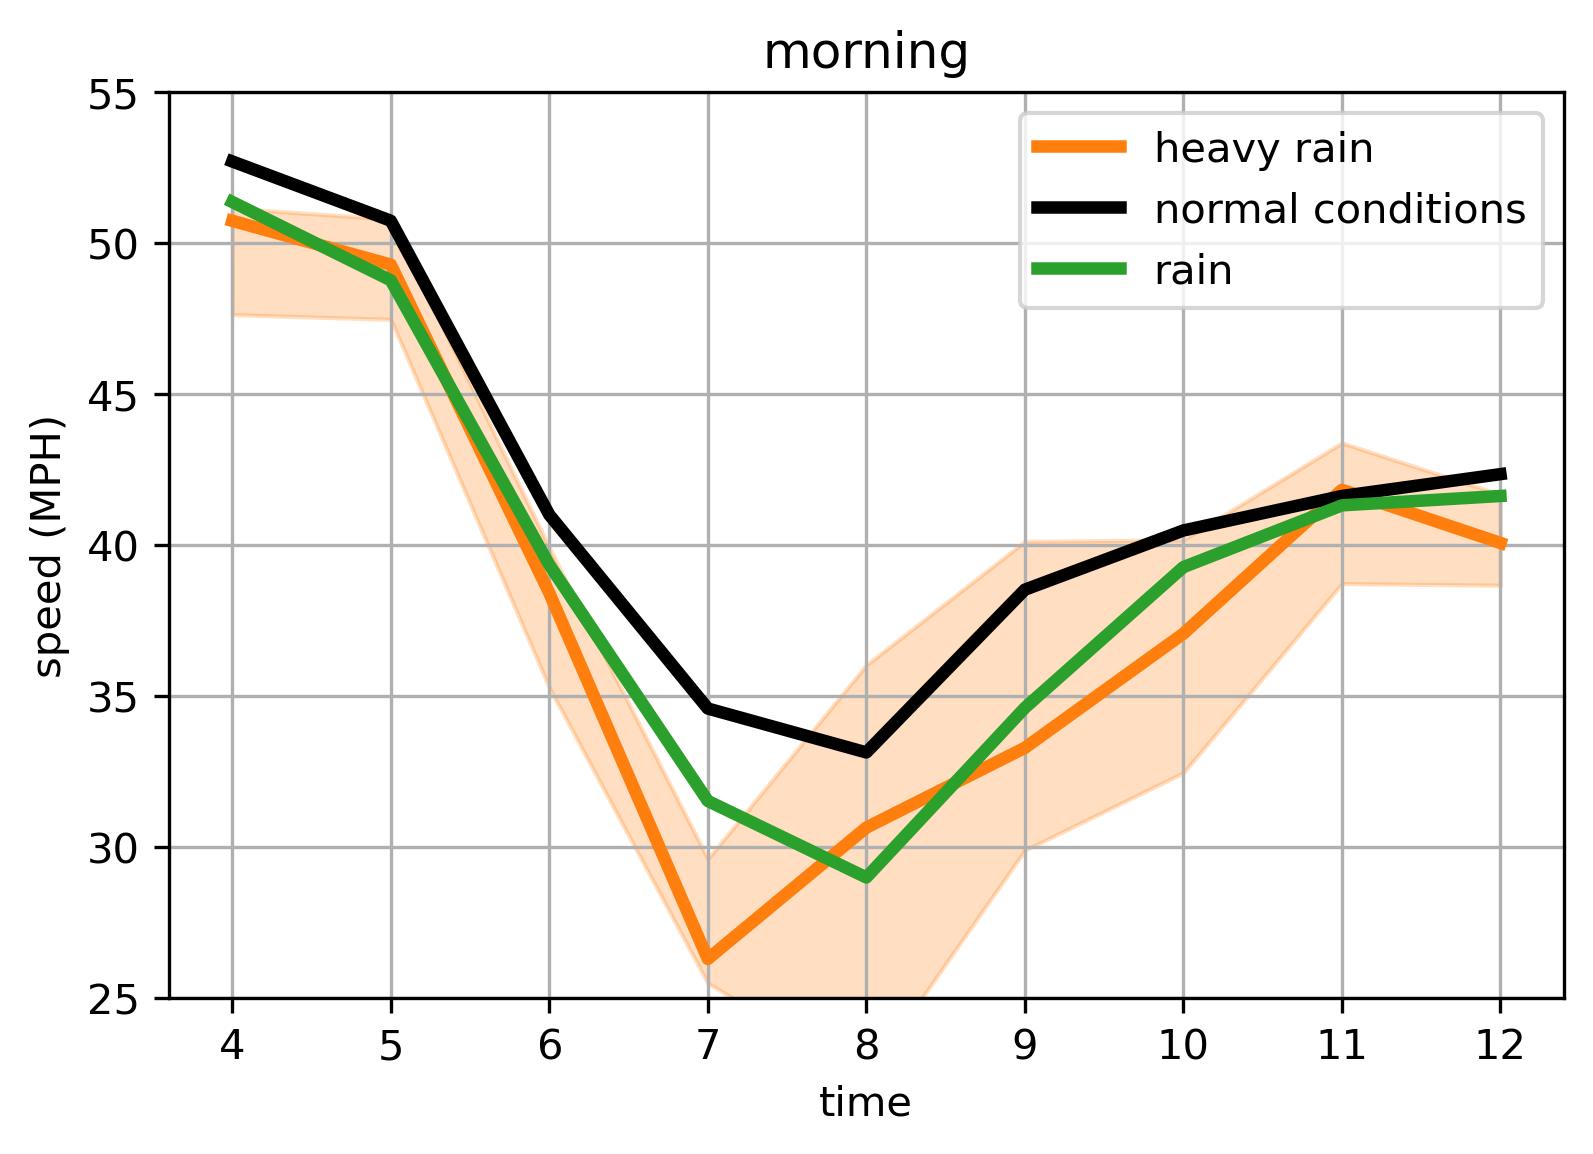

In [28]:
plt.figure(dpi=300)

rainy = df_norm[(df_norm['p01i']>0) & (df_norm['lt_32']<1)]
hrain = df_norm[(df_norm['p01i']>0.5) & (df_norm['lt_32']<1)]
normal = df_norm['speed'].groupby(df_norm['speed'].index.hour).median()*df['speed'].std()+df['speed'].mean()

rainy['speed'] = rainy['speed']*df['speed'].std()+df['speed'].mean()
hrain['speed'] = hrain['speed']*df['speed'].std()+df['speed'].mean()


uq = hrain.groupby(hrain.index.hour)['speed'].quantile(.75)
lq = hrain.groupby(hrain.index.hour)['speed'].quantile(.25)
median = hrain.groupby(hrain.index.hour).median()['speed']

median.plot(lw=3,label='heavy rain',c='tab:orange')
plt.fill_between(uq.index,uq,lq,alpha=0.25,color='tab:orange')

normal.plot(label='normal conditions',lw=3,c='k')
rainy.groupby(rainy.index.hour).median()['speed'].plot(label='rain',lw=3,c='tab:green')

plt.grid()
plt.ylabel('speed (MPH)')
plt.legend()
plt.ylim(25,55)
plt.title(ampm)